In [2]:
!conda create -n celloracle python=3.8
!conda activate celloracle
!pip install celloracle Cython numpy scvelo leidenalg scanpy

/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scvelo as scv #just using for dataset


import celloracle as co
from celloracle.applications import Pseudotime_calculator
from celloracle.applications import Gradient_calculator
from celloracle.applications import Oracle_development_module

2024-06-12 17:12:42,112 - INFO - Creating new config.
INFO:gimme.config:Creating new config.
2024-06-12 17:12:42,142 - INFO - Using included version of AMD.
INFO:gimme.config:Using included version of AMD.
2024-06-12 17:12:42,157 - INFO - Using included version of BioProspector.
INFO:gimme.config:Using included version of BioProspector.
2024-06-12 17:12:42,172 - INFO - Using included version of ChIPMunk.
INFO:gimme.config:Using included version of ChIPMunk.
2024-06-12 17:12:42,178 - WARNING - DiNAMO not found. To include it you will have to install it.
2024-06-12 17:12:42,185 - WARNING - DREME not found. To include it you will have to install it.
2024-06-12 17:12:42,197 - WARNING - GADEM not found. To include it you will have to install it.
2024-06-12 17:12:42,204 - INFO - Using included version of HMS.
INFO:gimme.config:Using included version of HMS.
2024-06-12 17:12:42,216 - WARNING - Homer not found. To include it you will have to install it.
2024-06-12 17:12:42,223 - INFO - Using i

In [4]:
%matplotlib inline

In [5]:
adata = scv.datasets.pancreas()

  0%|          | 0.00/50.0M [00:00<?, ?B/s]

In [6]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [7]:
#just clearing things I dont need
adata.var = adata.var.drop(columns = ['highly_variable_genes'])
adata.uns = {}
adata.obsp = {}
adata.obsm = {}

In [8]:
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    layers: 'spliced', 'unspliced'

In [9]:
adata.layers['counts'] = adata.X.copy()

In [10]:
sc.pp.filter_genes(adata, min_cells = 1)

In [11]:
#YOU SHOULD DO PREPROCESSING IF DATA ISNT ALREADY, NOT SHOWN
#e.g, doublet removal, ambient rna removal, MAD filtering of outliers
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [12]:
adata.raw = adata

In [13]:
sc.pp.highly_variable_genes(adata, subset = True, inplace = True)

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.3)

In [15]:
sc.tl.umap(adata)

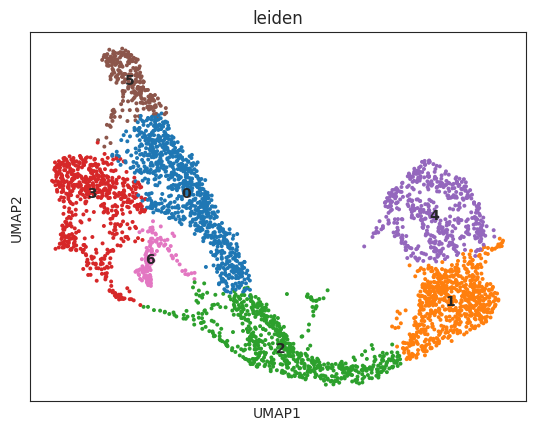

In [16]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

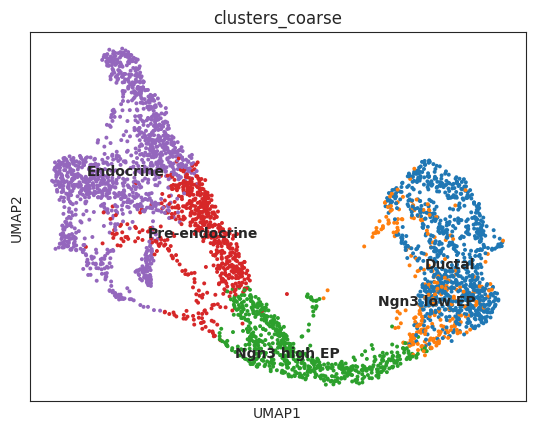

In [17]:
sc.pl.umap(adata, color='clusters_coarse', legend_loc='on data')

In [18]:
pt = Pseudotime_calculator(adata=adata,
                           obsm_key="X_umap", # Dimensional reduction data name
                           cluster_column_name="leiden" # Clustering data name
                           )

In [19]:
lineage_dict = {'the_one':adata.obs.leiden.unique().tolist()} #can have multiple lineages

In [20]:
lineage_dict

{'the_one': ['0', '1', '4', '2', '3', '6', '5']}

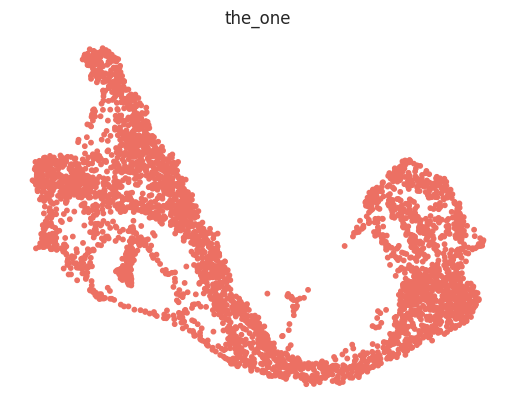

In [21]:
pt.set_lineage(lineage_dictionary=lineage_dict)
pt.plot_lineages()

In [22]:
# #find minimum/max
# y_coords = adata.obsm['X_umap'][:, 1] #change 1 to 0 for minimum x value
# min_y = pd.Series(y_coords).idxmin() #min to max for max values
# root_cells = {"the_one": adata.obs_names[min_y]}

In [23]:
#picking the cell with the highest x + y value:
coord_sum = adata.obsm['X_umap'].sum(axis = 1)
max_sum = pd.Series(coord_sum).idxmax()
root_cells = {"the_one": adata.obs_names[max_sum]}

In [24]:
#using plotly to select cell with mouse:
#https://morris-lab.github.io/CellOracle.documentation/notebooks/05_simulation/Pseudotime_calculation_with_Paul_etal_2015_data.html#2.-Pseudotime-calculation

In [25]:
root_cells

{'the_one': 'GTAACTGTCAGTGCAT'}

In [26]:
pt.set_root_cells(root_cells=root_cells)

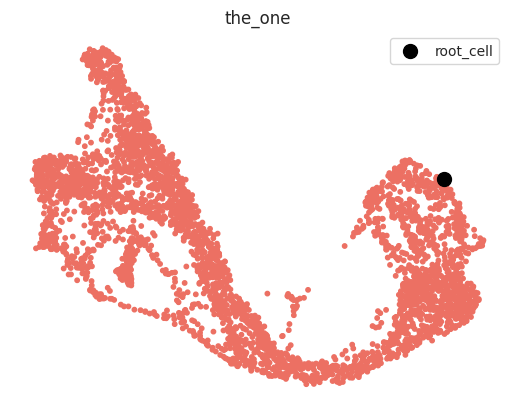

In [27]:
pt.plot_root_cells()

In [28]:
sc.tl.diffmap(pt.adata)

In [29]:
pt.get_pseudotime_per_each_lineage()

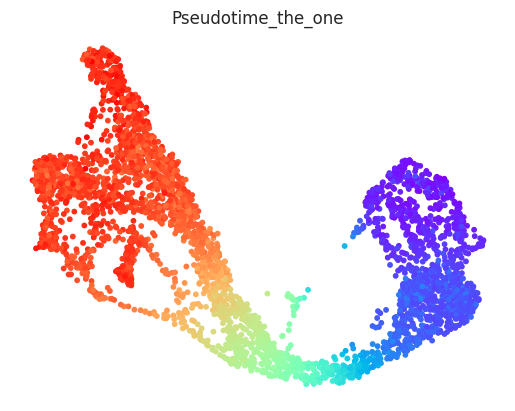

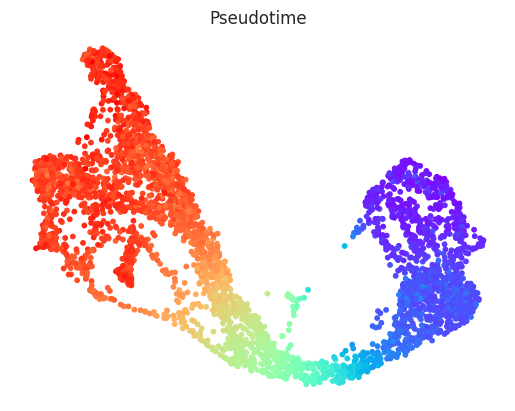

<Figure size 640x480 with 0 Axes>

In [30]:
pt.plot_pseudotime(cmap="rainbow")

plt.savefig('pt.png', dpi = 300)


In [31]:
pt.adata.obs

clusters_coarse       clusters   S_score  G2M_score leiden  \
index                                                                         
AAACCTGAGAGGGATA   Pre-endocrine  Pre-endocrine -0.224902  -0.252071      0   
AAACCTGAGCCTTGAT          Ductal         Ductal -0.014707  -0.232610      1   
AAACCTGAGGCAATTA       Endocrine          Alpha -0.171255  -0.286834      0   
AAACCTGCATCATCCC          Ductal         Ductal  0.599244   0.191243      4   
AAACCTGGTAAGTGGC    Ngn3 high EP   Ngn3 high EP -0.179981  -0.126030      2   
...                          ...            ...       ...        ...    ...   
TTTGTCAAGTGACATA   Pre-endocrine  Pre-endocrine -0.235896  -0.266101      0   
TTTGTCAAGTGTGGCA    Ngn3 high EP   Ngn3 high EP  0.279374  -0.204047      2   
TTTGTCAGTTGTTTGG          Ductal         Ductal -0.045692  -0.208907      1   
TTTGTCATCGAATGCT       Endocrine          Alpha -0.240576  -0.206865      3   
TTTGTCATCTGTTTGT       Endocrine        Epsilon -0.136407  -0.184763      3   

                 the_one  Pseudotime_the_one  Pseudotime  
index                                                     
AAACCTGAGAGGGATA    True            0.918898    0.918898  
AAACCTGAGCCTTGAT    True            0.096967    0.096967  
AAACCTGAGGCAATTA    True            0.914116    0.914116  
AAACCTGCATCATCCC    True            0.053107    0.053107  
AAACCTGGTAAGTGGC    True            0.687594    0.687594  
...                  ...                 ...         ...  
TTTGTCAAGTGACATA    True            0.874455    0.874455  
TTTGTCAAGTGTGGCA    True            0.573512    0.573512  
TTTGTCAGTTGTTTGG    True            0.116973    0.116973  
TTTGTCATCGAATGCT    True            0.935888    0.935888  
TTTGTCATCTGTTTGT    True            0.875846    0.875846  

[3696 rows x 8 columns]

In [32]:
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()

Data not found in the local folder. Loading data from github. Data will be saved at /root/celloracle_data/TFinfo_data


  0%|          | 0.00/9.01M [00:00<?, ?B/s]

In [33]:
base_GRN

peak_id gene_short_name  9430076c15rik  Ac002126.6  \
0      chr10_100050979_100052296   4930430F08Rik            0.0         0.0   
1      chr10_101006922_101007748         SNORA17            0.0         0.0   
2      chr10_101144061_101145000          Mgat4c            0.0         0.0   
3        chr10_10148873_10149183   9130014G24Rik            0.0         0.0   
4        chr10_10149425_10149815   9130014G24Rik            0.0         0.0   
...                          ...             ...            ...         ...   
91971     chrX_99839037_99840900           Phka1            0.0         0.0   
91972         chrY_345823_347369         Eif2s3y            0.0         0.0   
91973         chrY_581272_582790             Uty            0.0         0.0   
91974         chrY_621772_623366           Ddx3y            0.0         0.0   
91975         chrY_795887_796426           Usp9y            0.0         0.0   

       Ac012531.1  Ac226150.2  Afp  Ahr  Ahrr  Aire  ...  Znf784  Znf8  \
0             1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
1             0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
2             0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
3             0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
4             0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
...           ...         ...  ...  ...   ...   ...  ...     ...   ...   
91971         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
91972         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
91973         1.0         0.0  0.0  0.0   0.0   0.0  ...     1.0   0.0   
91974         1.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0   
91975         0.0         0.0  0.0  0.0   0.0   1.0  ...     0.0   0.0   

       Znf816  Znf85  Zscan10  Zscan16  Zscan22  Zscan26  Zscan31  Zscan4  
0         0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1         0.0    0.0      0.0      0.0      0.0      0.0      1.0     0.0  
2         0.0    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
3         0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4         0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
...       ...    ...      ...      ...      ...      ...      ...     ...  
91971     0.0    0.0      0.0      0.0      0.0      0.0      0.0     1.0  
91972     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
91973     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
91974     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
91975     0.0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[91976 rows x 1095 columns]

In [34]:
adata.X = adata.layers['counts'].copy()

In [35]:
oracle = co.Oracle()

In [36]:
oracle.import_anndata_as_raw_count(adata = adata, cluster_column_name = 'leiden', embedding_name = 'X_umap')

In [37]:
adata.X.max()

2286.0

In [38]:
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [39]:
oracle.perform_PCA()

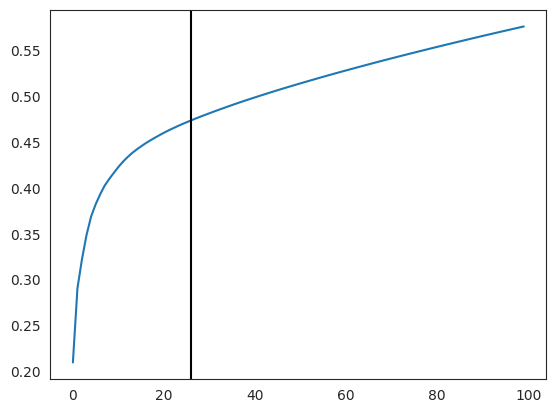

26


In [40]:
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [41]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :3696


In [42]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :92


In [43]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [44]:
%%time

links = oracle.get_links(cluster_name_for_GRN_unit="leiden", alpha=10,
                         verbose_level=10)

  0%|          | 0/7 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/1616 [00:00<?, ?it/s]

Inferring GRN for 1...


  0%|          | 0/1616 [00:00<?, ?it/s]

Inferring GRN for 2...


  0%|          | 0/1616 [00:00<?, ?it/s]

Inferring GRN for 3...


  0%|          | 0/1616 [00:00<?, ?it/s]

Inferring GRN for 4...


  0%|          | 0/1616 [00:00<?, ?it/s]

Inferring GRN for 5...


  0%|          | 0/1616 [00:00<?, ?it/s]

Inferring GRN for 6...


  0%|          | 0/1616 [00:00<?, ?it/s]

CPU times: user 12min 13s, sys: 16.3 s, total: 12min 29s
Wall time: 22min 49s


In [45]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=10000) #10k is default top num to keep

0


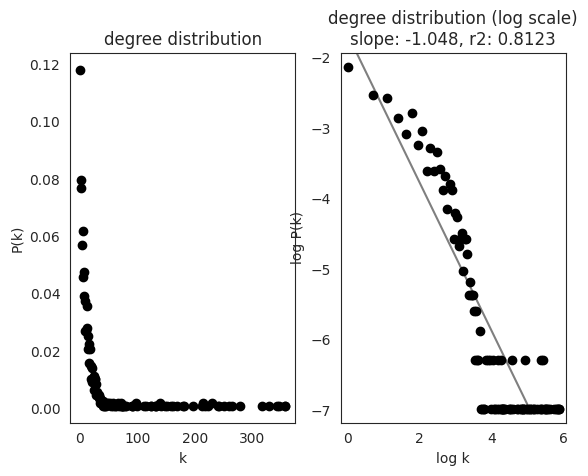

1


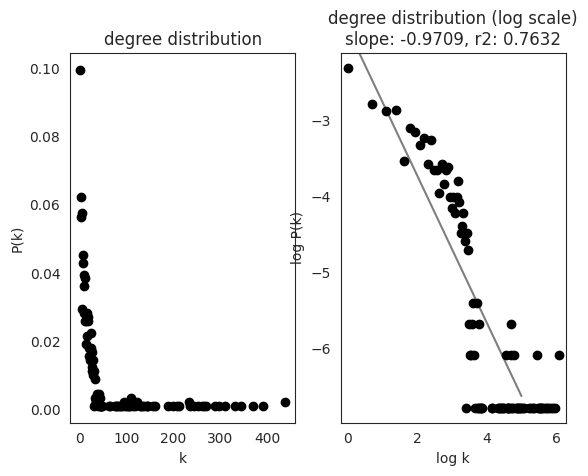

2


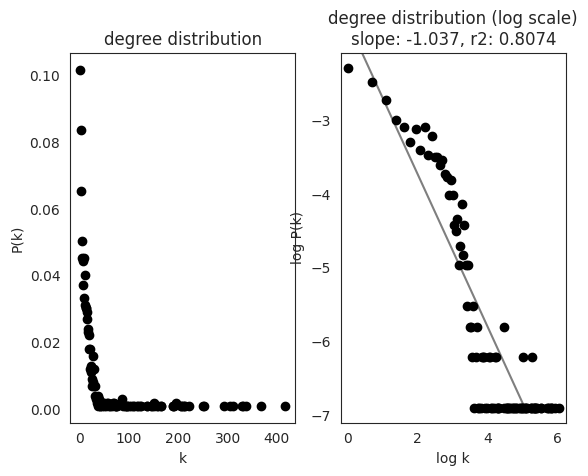

3


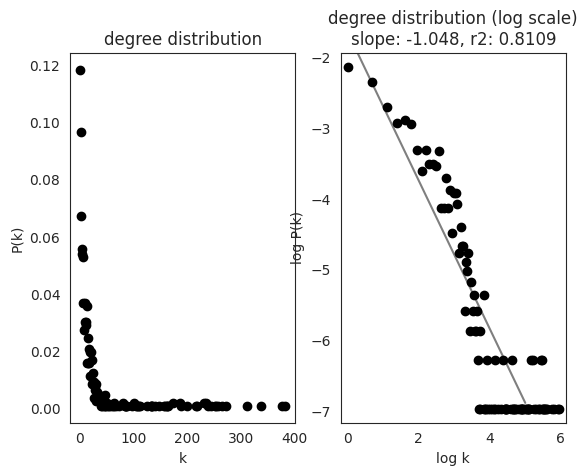

4


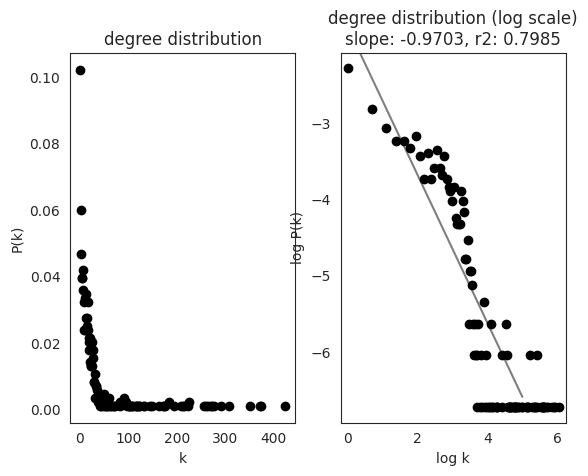

5


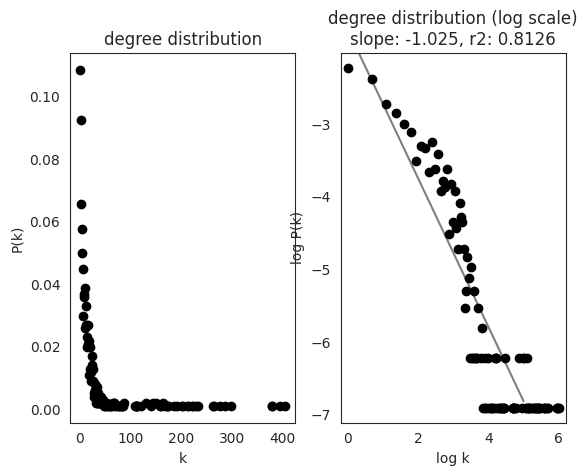

6


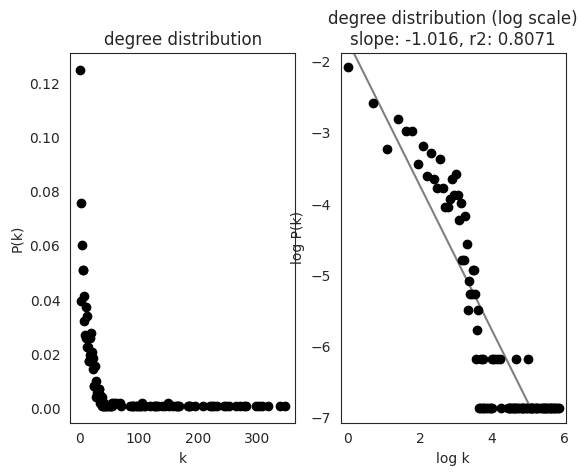

In [46]:
links.plot_degree_distributions(plot_model=True)

In [47]:
links.get_network_score()

In [48]:
links.merged_score

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
Klf13           349               0.327392         10              0.009381   
Neurog3         152               0.142589          2              0.001876   
Insm1           166               0.155722         19              0.017824   
Nnat             22               0.020638         22              0.020638   
Nr4a1            98               0.091932          0              0.000000   
...             ...                    ...        ...                   ...   
Tspyl4            1               0.001042          1              0.001042   
Lmo3              1               0.001042          1              0.001042   
Derl3             1               0.001042          1              0.001042   
Cog1              1               0.001042          1              0.001042   
Kctd15            1               0.001042          1              0.001042   

         degree_out  degree_centrality_out  betweenness_centrality  \
Klf13           339               0.318011                  4153.0   
Neurog3         150               0.140713                   174.0   
Insm1           147               0.137899                  2941.0   
Nnat              0               0.000000                     0.0   
Nr4a1            98               0.091932                     0.0   
...             ...                    ...                     ...   
Tspyl4            0               0.000000                     0.0   
Lmo3              0               0.000000                     0.0   
Derl3             0               0.000000                     0.0   
Cog1              0               0.000000                     0.0   
Kctd15            0               0.000000                     0.0   

         eigenvector_centrality cluster  
Klf13                  1.000000       0  
Neurog3                0.531114       0  
Insm1                  0.454131       0  
Nnat                   0.718826       0  
Nr4a1                  0.234590       0  
...                         ...     ...  
Tspyl4                 0.000654       6  
Lmo3                   0.000618       6  
Derl3                  0.000643       6  
Cog1                   0.001078       6  
Kctd15                 0.000137       6  

[6797 rows x 9 columns]

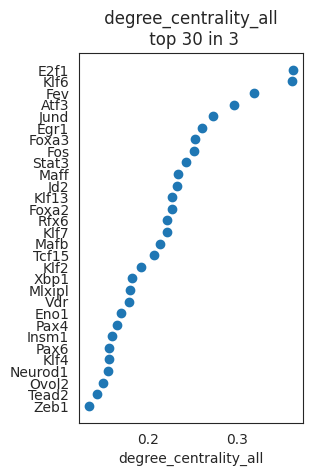

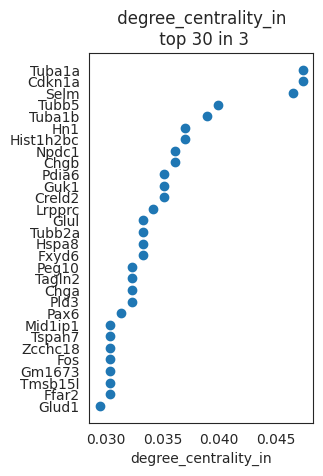

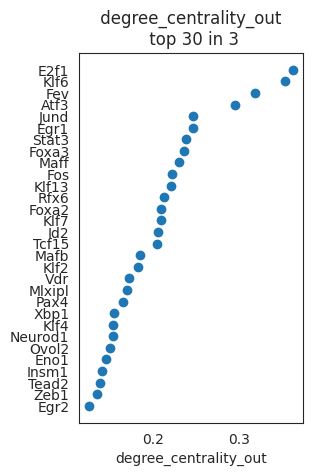

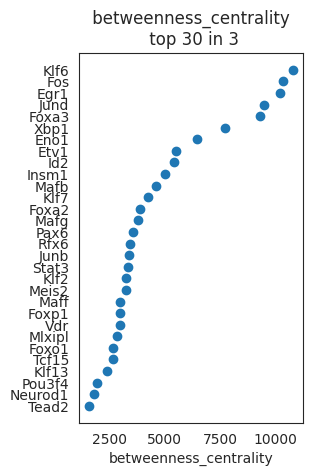

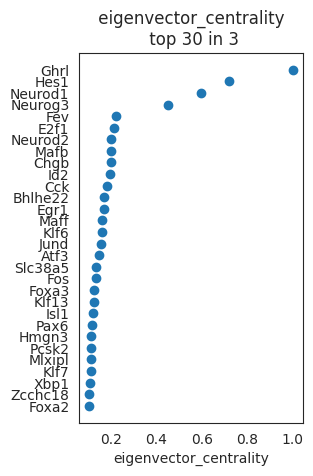

In [49]:
links.plot_scores_as_rank(cluster="3", n_gene=30)

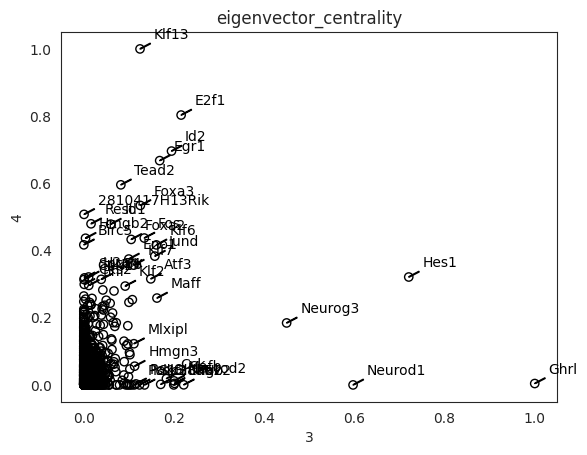

In [50]:
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="3", cluster2="4",
                               percentile=98)

Mafb


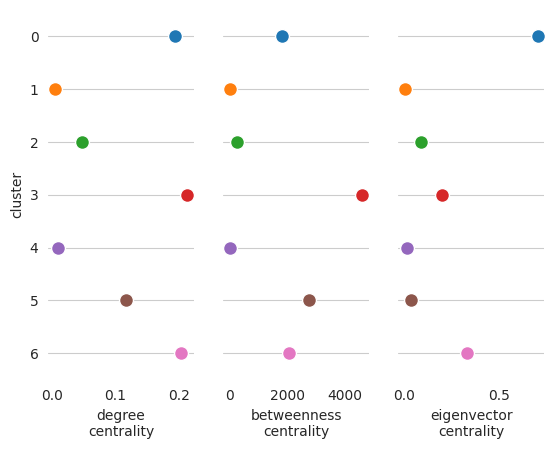

In [51]:
links.plot_score_per_cluster(goi="Mafb")

In [52]:
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

  0%|          | 0/7 [00:00<?, ?it/s]

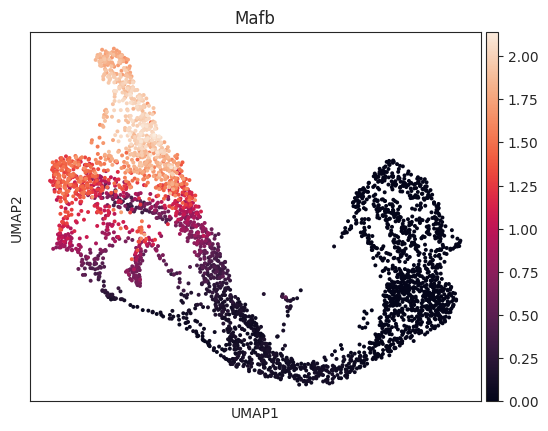

In [53]:
sc.pl.umap(oracle.adata, color = ['Mafb'], layer="imputed_count")

In [54]:
oracle.simulate_shift(perturb_condition={'Mafb': 0.0}, n_propagation=3)

In [55]:
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

oracle.calculate_embedding_shift(sigma_corr=0.05)

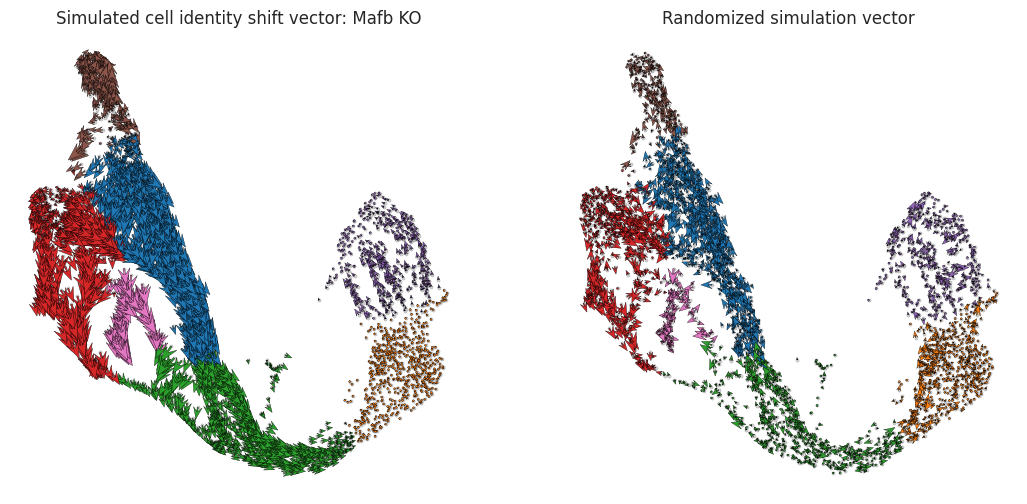

In [56]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 30 #bigger = smaller vector
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: Mafb KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()


In [57]:
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

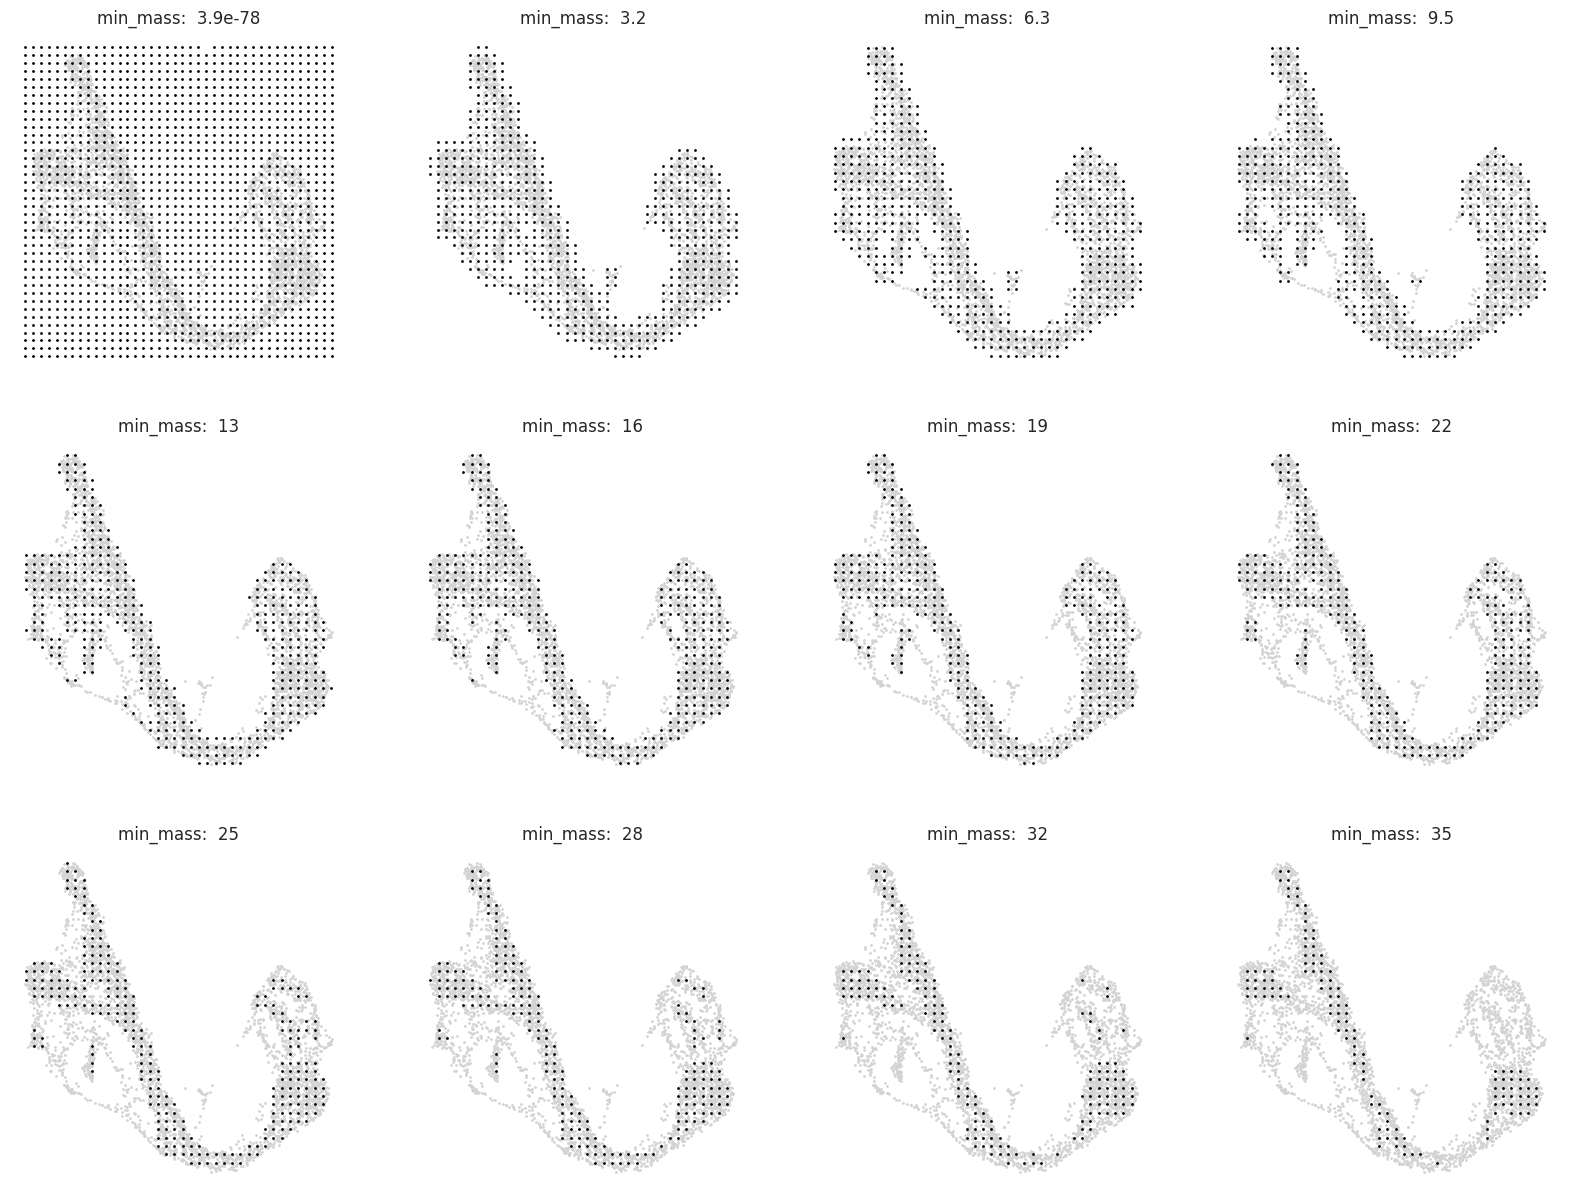

In [58]:
oracle.suggest_mass_thresholds(n_suggestion=12)

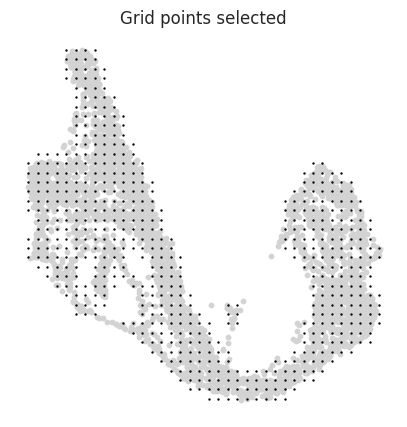

In [59]:
min_mass = 6.2
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

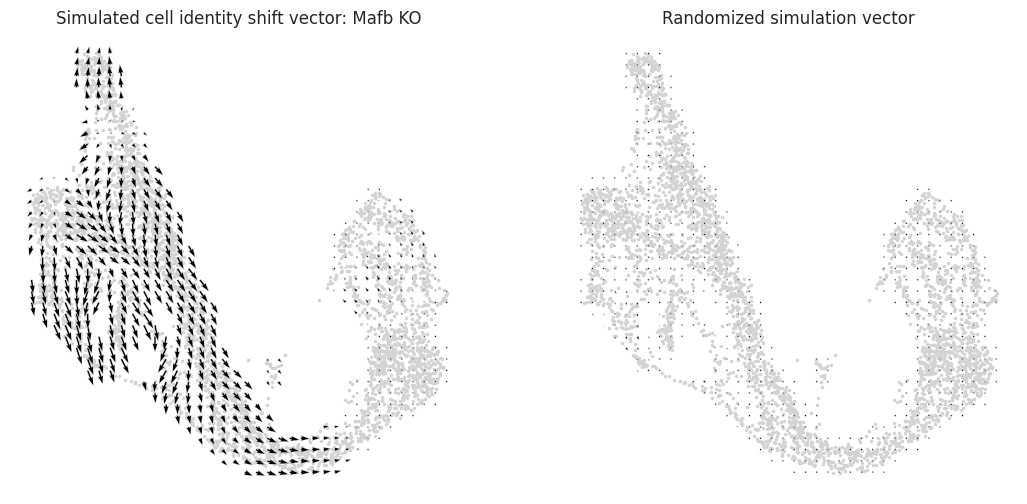

In [60]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 30
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: Mafb KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

In [61]:
oracle.adata.obs['Pseudotime'] = pt.adata.obs.Pseudotime

In [62]:
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

In [63]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=False)

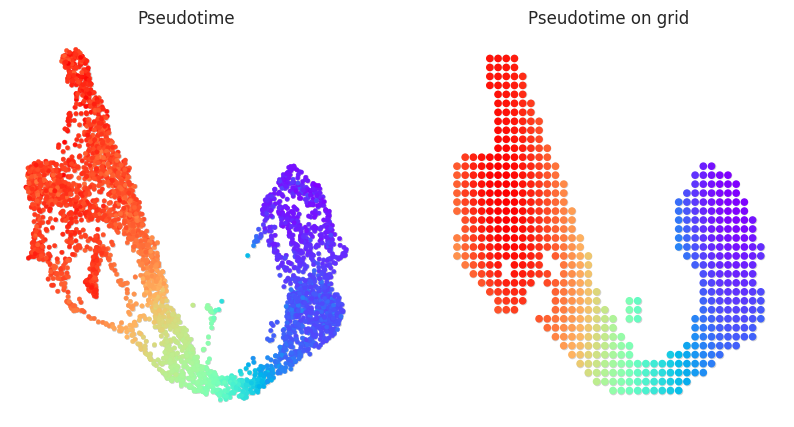

In [64]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

In [65]:
gradient.calculate_gradient()

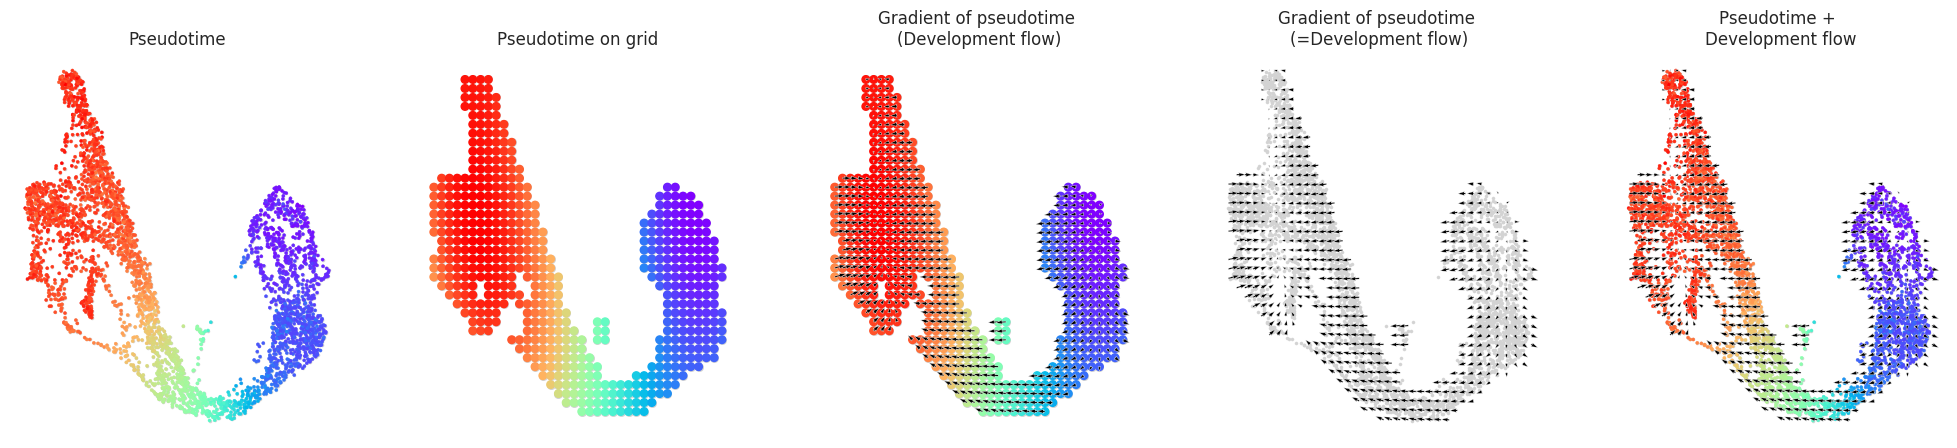

In [66]:
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

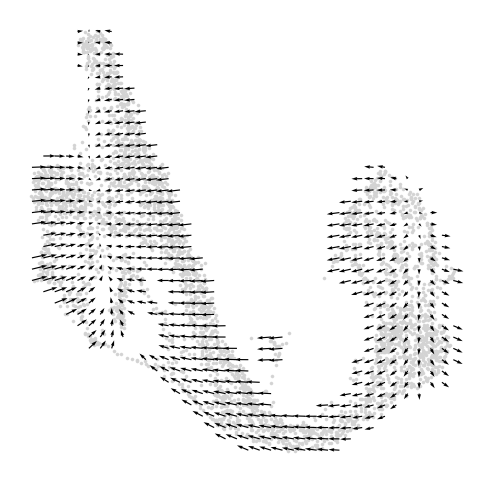

In [67]:
# pseudotime gradient
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [68]:
dev = Oracle_development_module()

In [69]:
dev.load_differentiation_reference_data(gradient_object=gradient)

In [70]:
dev.load_perturb_simulation_data(oracle_object=oracle)

In [71]:
# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

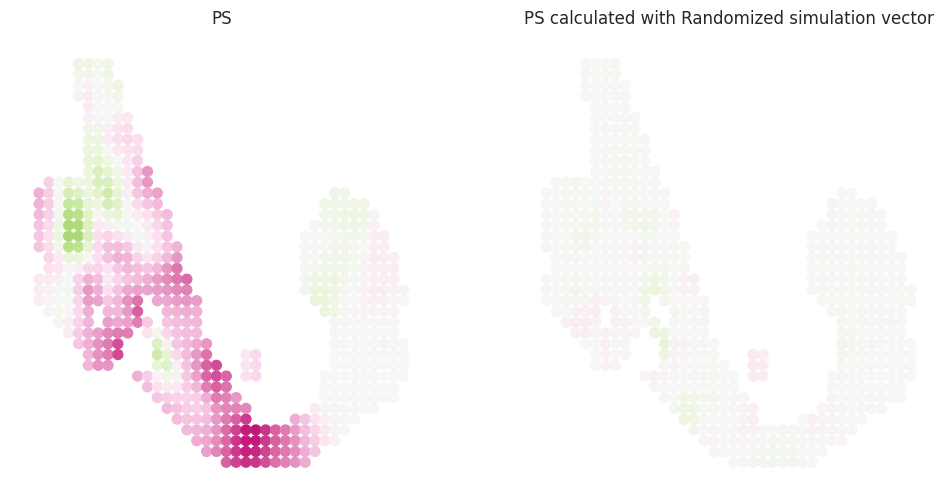

In [72]:
# Show perturbation scores
vm = 1 #adjust based on data

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax[0])
ax[0].set_title(f"PS")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS calculated with Randomized simulation vector")
plt.show()

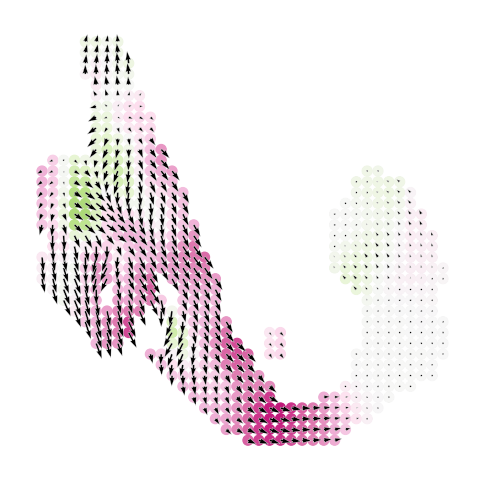

In [73]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

plt.savefig('pertubation_score.png', dpi = 300)